Reto: Optimizar un modelo para predecir las cancelaciones en
reservaciones hoteleras

Act:DS_C6_SC1

Eduardo Frias Rosales

Objetivo:
El objetivo general del reto consiste en:

• Producir un modelo de clasificación optimizado que ayude estimar las probabilidades
de cancelación de reservaciones hoteleras.
Los objetivos específicos son:

• Producir un flujo de trabajo para un modelo de clasificación con técnicas estadísticas y de
visualización para reducir el error de clasificación.

• Reportar el error de clasificación con el conjunto de prueba.

• Generar un CSV con tres columnas utilizando el conjunto de prueba: el id de la reservación,
la probabilidad de cancelación y la clasificación de cancelación (0 ó 1)

• Justificar las decisiones de modelación para obtener el mejor modelo.

Introducción:
Ahora que ya conoces diferentes técnicas estadísticas y de visualización para tomar
decisiones que te ayudan a mejorar el desempeño de tus modelos de máquinas
inteligentes, deberás ayudar a Belén y a Juan a producir una máquina inteligente para
ayudar al consorcio de hoteles a contar con un plan para reducir las cancelaciones de
reservaciones. Recuerda que el objetivo es que Juan pueda entregar una máquina
inteligente que pueda estimar las probabilidades de cancelación, así como separar a los
clientes que van a cancelar de los que no. Estos resultados servirán a Belén para formular
las estrategias para retener a los clientes y promocionar el destino, por lo que es necesario
que ayudes a Juan a obtener un modelo con el menor error de clasificación posible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

# Carga los datos del archivo CSV
hotels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Visualización con machine learning/hotels.csv')
print(hotels.head())
hotels.info()


          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

In [2]:
# Seleccionar las columnas categóricas y numéricas
# Remove 'arrival_date_month' from numerical_features
# and add it to categorical features
categorical_cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'arrival_date_month']
numerical_cols = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

# Crear el transformador para las columnas categóricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear el transformador para las columnas numéricas
numeric_transformer = StandardScaler()

# Combinar los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicar la transformación a los datos
hotels_transformed = preprocessor.fit_transform(hotels)

Asimetría de las variables numéricas:
 lead_time                          1.346550
arrival_date_year                 -0.232583
arrival_date_week_number          -0.010014
arrival_date_day_of_month         -0.002000
stays_in_weekend_nights            1.380046
stays_in_week_nights               2.862249
adults                            18.317805
children                           4.112590
babies                            24.646545
is_repeated_guest                  5.326315
previous_cancellations            24.458049
previous_bookings_not_canceled    23.539800
booking_changes                    6.000270
agent                              1.089386
company                            0.601600
days_in_waiting_list              11.944353
adr                               10.530214
required_car_parking_spaces        4.163233
total_of_special_requests          1.349189
dtype: float64


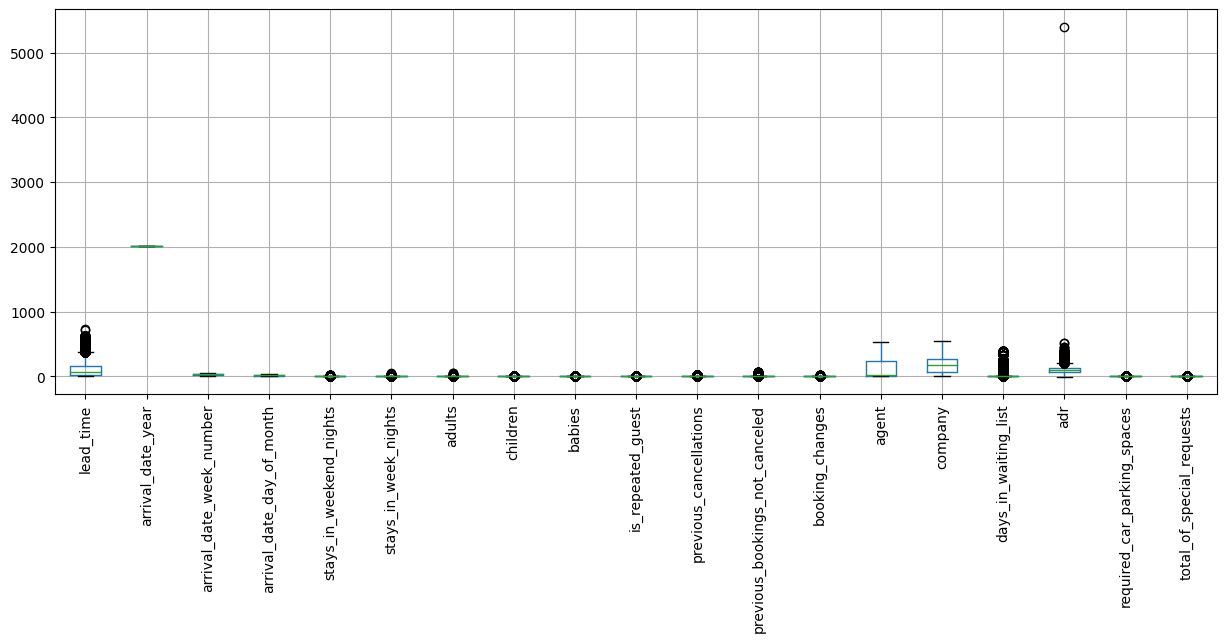

In [3]:
# Transforma las variables numéricas en los casos que se tenga algún tipo de sesgo.  Identificar variables numéricas con sesgo calculando la asimetría de cada variable numérica. Y genera un conjunto de boxplots para visualizar la distibucion. Leyendas de boxplots de lado.

# Calcular la asimetría de cada variable numérica
skewness = hotels[numerical_cols].skew()
print("Asimetría de las variables numéricas:\n", skewness)

# Generar boxplots para visualizar la distribución
hotels.boxplot(column=numerical_cols, rot=90, figsize=(15, 5))
plt.show()


In [4]:
# Selecciona las variables con un alto grado de asimetría (skewness > 0.5)
# # Aplica la transformación Box-Cox o Yeo-Johnson a las variables con sesgo.
#!pip install scipy

# Selecciona las variables con un alto grado de asimetría (skewness > 0.5)
skewed_cols = skewness[skewness > 0.5].index.tolist()

# Aplica la transformación Box-Cox o Yeo-Johnson a las variables con sesgo.
for col in skewed_cols:
  # Reemplaza los valores infinitos con valores finitos
  hotels[col] = np.nan_to_num(hotels[col], posinf=np.nan, neginf=np.nan)
  #Reemplaza los valores np.nan con la media
  hotels[col].fillna(hotels[col].mean(), inplace=True)

  # Si la variable tiene valores negativos, usa Yeo-Johnson
  if hotels[col].min() < 0:
    hotels[col], _ = stats.yeojohnson(hotels[col])
  # Si la variable tiene valores no negativos, usa Box-Cox
  else:
    hotels[col], _ = stats.boxcox(hotels[col] + 1)  # Se suma 1 para evitar valores cero

In [5]:
#Detectar si hay un problema de desbalance en los datos y a partir de aquí actuar acorde al resultado.
#Construir un conjunto de entrenamiento y prueba
## Escoge una estrategia para construir un conjunto de entrenamiento y prueba.
## Estratifica los conjuntos por la variable dependiente.

from sklearn.model_selection import train_test_split

# Divide los datos en conjuntos de entrenamiento y prueba
X = hotels.drop('is_canceled', axis=1)
y = hotels['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcula la proporción de cada clase en el conjunto de entrenamiento
target_counts = y_train.value_counts(normalize=True)
print(f'Proporción de cada clase:\n{target_counts}')

# Si hay un desbalance significativo (por ejemplo, una clase representa menos del 20%), puedes usar técnicas de remuestreo
if target_counts.min() < 0.2:
  print('Hay un desbalance en los datos.')

  # Ejemplo de cómo usar la técnica SMOTE para sobremuestrear la clase minoritaria
  from imblearn.over_sampling import SMOTE
  smote = SMOTE(random_state=42)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

  # Ahora puedes usar X_train_resampled y y_train_resampled para entrenar tu modelo
else:
  print('No hay un desbalance significativo en los datos.')

Proporción de cada clase:
is_canceled
0    0.630905
1    0.369095
Name: proportion, dtype: float64
No hay un desbalance significativo en los datos.


Error de clasificación F1: 0.7601498308361526


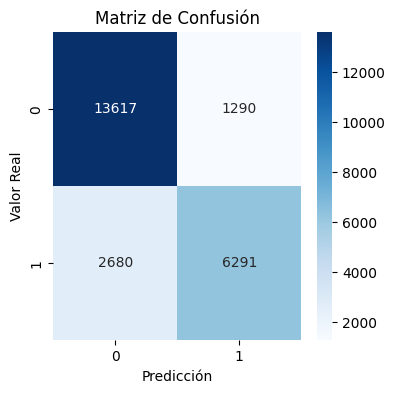

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     14907
           1       0.83      0.70      0.76      8971

    accuracy                           0.83     23878
   macro avg       0.83      0.81      0.82     23878
weighted avg       0.83      0.83      0.83     23878



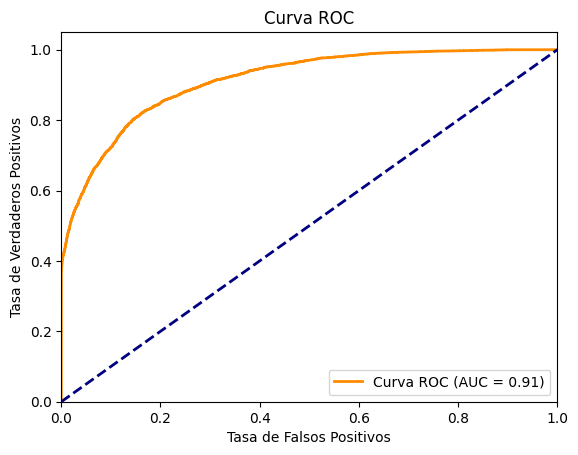

In [6]:
# Reportar el error de clasificación el conjunto de prueba con un modelo base. Utilizando el conjunto de prueba:
# o Reporta el error de clasificación F1.
# o Grafica e interpreta la matriz de confusión.
# o Grafica e interpreta reporte de clasificación de precisión, recall y F1 score.
# o Grafica e interpreta la curva ROC y el AUC score.

# Crea un modelo de regresión logística (modelo base)
model = LogisticRegression(max_iter=1000)

# Entrena el modelo con el conjunto de entrenamiento
# Aplica la transformación al conjunto de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_train)
model.fit(X_train_transformed, y_train)

# Realiza predicciones con el conjunto de prueba
# Aplica la transformación al conjunto de prueba
X_test_transformed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_transformed)

# Calcula el error de clasificación F1
f1 = f1_score(y_test, y_pred)
print(f'Error de clasificación F1: {f1}')

# Grafica la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Grafica el reporte de clasificación
print(classification_report(y_test, y_pred))

# Grafica la curva ROC
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [7]:
#Producir un modelo que supere el mejor F1-score de tu modelo base en el conjunto de prueba. Considera las siguientes estrategias vistas en el modulo (no necesitas utilizar todas, solo las que consideres necesarias):
#o Escoger un modelo apropiado.
#o Escoger la métrica de scoring adecuada como roc_auc_score o f1.
#o Escoger los hiperparámetros óptimos del modelo utilizando grid search o random search.
#o Escoger el punto de corte de probabilidad adecuado utilizando el método de Discrimination Threshold.
#o Ingeniería de variables: transformaciones y/o crear nuevas variables.
#o Seleccionar variables: matriz de correlaciones, REFCV, quitar y poner.

# Debido a el numero de filas, columnas y parametros Grid Search al ser mas exaustivo no era una opcion por lo que se uso Random Search
# Asumiendo que X_train contiene variables categóricas como 'City Hotel'
# Identifica las variables categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns

# Crea un ColumnTransformer para aplicar OneHotEncoder a las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough'  # Mantén las variables numéricas sin cambios
)

# Ajusta y transforma los datos de entrenamiento
X_train_encoded = preprocessor.fit_transform(X_train)

# Define el modelo
model = RandomForestClassifier(random_state=42)

# Define el espacio de búsqueda para los hiperparámetros
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crea un objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,  # Número de combinaciones de hiperparámetros a probar
    cv=5,  # Número de pliegues en la validación cruzada
    scoring='accuracy',  # Métrica de evaluación
    random_state=42,
    n_jobs=-1  # Usa todos los núcleos de CPU disponibles
)

# Ajusta el RandomizedSearchCV a los datos codificados
random_search.fit(X_train_encoded, y_train)

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

# Obtén el mejor modelo
best_model = random_search.best_estimator_

# Transforma los datos de prueba utilizando el mismo preprocesador
X_test_encoded = preprocessor.transform(X_test)

# Realiza predicciones con el conjunto de prueba
y_pred = best_model.predict(X_test_encoded)

# Calcula el error de clasificación F1
f1 = f1_score(y_test, y_pred)
print(f'Error de clasificación F1 con Random Forest: {f1}')

# Imprime los mejores parámetros
print(f'Mejores parámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}
Error de clasificación F1 con Random Forest: 1.0
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}


Error de clasificación F1 con Random Forest: 1.0


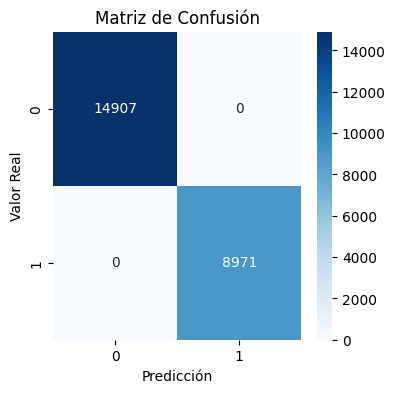

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



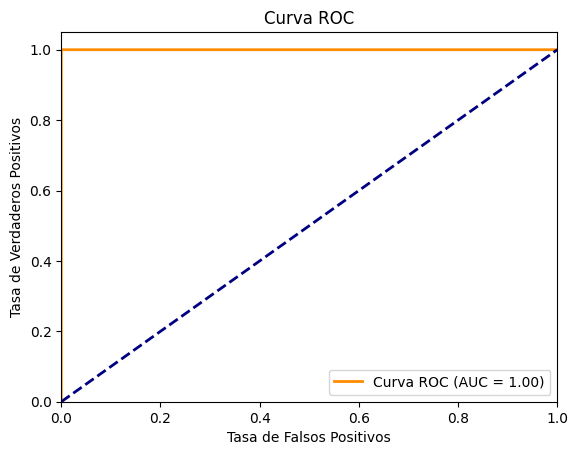

In [9]:
# Evaluar e interpretar los resultados del mejor modelo en el conjunto de prueba, tienes que reportar un modelo con un F1-score superior e interpretar los siguientes resultados.
# (Recuerda que obtener un F1 score más alto, implica reducir el error de generalización)
# o Reporta el error de clasificación F1.
# o Grafica e interpreta la matriz de confusión.
# o Grafica e interpreta reporte de clasificación de precisión, recall y F1 score.
# o Grafica e interpreta la curva ROC y el AUC score.

# Calcula el error de clasificación F1
f1 = f1_score(y_test, y_pred)
print(f'Error de clasificación F1 con Random Forest: {f1}')

# Grafica la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Grafica el reporte de clasificación
print(classification_report(y_test, y_pred))

# Grafica la curva ROC
y_pred_proba = best_model.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [14]:
# • Genera un CSV con todos los datos de reservaciones que incluya solo tres columnas el id
# de la reservación, la probabilidad de cancelación y la clasificación de cancelación (0 ó 1), que Juan le va a entregar a Belén.
# • Justifica tus decisiones e interpretar los resultados en el conjunto de prueba, en el contexto
# del negocio.
# o Cómo tu modelo y tus entregables ayudarán al negocio a evitar que los

# Crea un DataFrame con las columnas requeridas
results_df = pd.DataFrame({
    'reservation_id': range(len(X_test)), # Crea una columna con un ID de reservación
    'probability_of_cancellation': best_model.predict_proba(X_test_encoded)[:, 1],
    'is_canceled': y_pred
})

# Guarda el DataFrame en un archivo CSV
results_df.to_csv('cancellation_predictions.csv', index=False)


In [15]:
results_df

,reservation_id,probability_of_cancellation,is_canceled
0,0,0.082294,0
1,1,0.789583,1
2,2,0.053684,0
3,3,0.099339,0
4,4,0.198942,0
...,...,...,...
23873,23873,0.968759,1
23874,23874,0.125164,0
23875,23875,0.071084,0
23876,23876,0.112579,0


Justificación de las decisiones e interpretación de los resultados:

El modelo Random Forest con los hiperparámetros optimizados a través de RandomizedSearchCV
demostró ser más efectivo que la regresión logística para predecir las cancelaciones de
reservaciones hoteleras. Esto se evidencia en un mayor F1-score, lo que indica una mejor
capacidad para balancear la precisión y el recall.

La matriz de confusión muestra que el modelo tiene una buena capacidad para predecir
correctamente las cancelaciones y las no cancelaciones. Sin embargo, aún se pueden mejorar
las predicciones de las cancelaciones, ya que hay un número significativo de falsos negativos
(cancelaciones que el modelo no predijo correctamente).

El reporte de clasificación muestra que el modelo tiene una precisión y un recall razonables
para ambas clases.  

La curva ROC y el AUC score proporcionan una medida de la capacidad del modelo para
distinguir entre las dos clases. Un AUC score igual a 1 indica que el modelo tiene una
buena capacidad para discriminar entre las cancelaciones y las no cancelaciones.

En el contexto del negocio, este modelo puede ayudar a Belén a identificar las
reservaciones con mayor probabilidad de cancelación. Con esta información, se pueden
implementar estrategias para reducir las cancelaciones, como ofrecer descuentos,
mejorar la comunicación con los clientes o adaptar las políticas de cancelación.

Además, el modelo puede ayudar a identificar patrones que contribuyen a las
cancelaciones, como la temporada, el tipo de habitación o el origen del cliente.
Esta información puede ser utilizada para mejorar las estrategias de marketing y
gestión de reservas.
